# **01-Install Libraries**:


In [1]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=ac7b7adbc6440447685a9051f46bb1f229b157e9b3557e0141815dc10fa006ff
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [2]:
#Installing The Faiss Vector Database
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 27.8 MB/s eta 0:00:00


In [3]:
#Installing Gradio, to create simple UI
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing ins

In [4]:
#Importing Libraries
import numpy as np
import pandas as pd
from PIL import Image
from deepface import DeepFace
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.datasets import fetch_lfw_people
import faiss
import gradio as gr
import io

24-09-10 21:14:35 - Directory /root/.deepface has been created
24-09-10 21:14:35 - Directory /root/.deepface/weights has been created


# **02-Load Dataset:**

-----------Loading data from LFW-----------

In [5]:
# Loading LFW dataset
LFW = fetch_lfw_people(min_faces_per_person=40)
faces = LFW.images
labels = LFW.target_names
labels_indices = LFW.target

# Create labels for each face in the dataset (Because we're risking to have one single label attached to each person and not to each picture)
labels_list = [labels[i] for i in labels_indices]

# Check: the number of samples (pictures we have), the dimensions of the pics and the number of ppl we gonna treat
print("Number of pics we have:", faces.shape[0] )
print("Shape of Image:", faces.shape[1:] )
print("Number of people:", labels.shape[0] )


Number of pics we have: 1867
Shape of Image: (62, 47)
Number of people: 19


-----------Checking on the Dataset by displaying a random face-----------

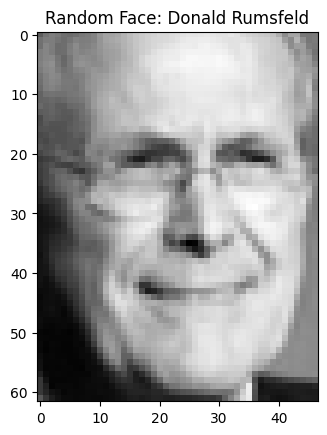

In [6]:
# Generating a random index for a random face
random_num = np.random.randint(0, len(faces))
random_face = faces[random_num]
label = labels[labels_indices[random_num]]
plt.imshow(random_face, cmap='gray')
plt.title(f"Random Face: {label}")
plt.show()

# **03-Extract Face Embeddings**

-----------Compute Face Embedding from Image-----------

In [7]:
def get_face_embedding(face_image):
    # Check if the images are Numpy array and convert to PIL Image Format
    if isinstance(face_image, np.ndarray):
        face_image = Image.fromarray(face_image)
    # Ensure image is in RGB Mode
    if face_image.mode != 'RGB':
        face_image = face_image.convert('RGB')
    # Save image temporarely for DeepFace
    temp_image_path = '/tmp/temp_face.jpg'
    face_image.save(temp_image_path)
    # Use FaceNet Model from DeepFace to get embeddings without face detection (face already detected)
    try:
        embeddings = DeepFace.represent(img_path=temp_image_path, model_name='Facenet', enforce_detection=False)
        return embeddings[0]['embedding']
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None


-----------Extract Embeddings for All Faces in the Dataset-----------

In [8]:
# Initialize an empty list to store embeddings of each face
embeddings_list = []
for i, face in enumerate(faces):
    # Keep track of how many faces have been processed
    print(f"Processing face {i+1}/{faces.shape[0]}")
    #Convert each face image to PIL format and scale pixel values
    face_image = Image.fromarray((face * 255).astype(np.uint8))
    #Call get_face_embedding (the old function) to get the embedding for each face
    embedding = get_face_embedding(face_image)
    if embedding is not None:
        embeddings_list.append(embedding)
    else:
        print(f"Failed to get embedding for face {i+1}")

Processing face 1/1867
24-09-10 21:15:25 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 155MB/s]


Processing face 2/1867
Processing face 3/1867
Processing face 4/1867
Processing face 5/1867
Processing face 6/1867
Processing face 7/1867
Processing face 8/1867
Processing face 9/1867
Processing face 10/1867
Processing face 11/1867
Processing face 12/1867
Processing face 13/1867
Processing face 14/1867
Processing face 15/1867
Processing face 16/1867
Processing face 17/1867
Processing face 18/1867
Processing face 19/1867
Processing face 20/1867
Processing face 21/1867
Processing face 22/1867
Processing face 23/1867
Processing face 24/1867
Processing face 25/1867
Processing face 26/1867
Processing face 27/1867
Processing face 28/1867
Processing face 29/1867
Processing face 30/1867
Processing face 31/1867
Processing face 32/1867
Processing face 33/1867
Processing face 34/1867
Processing face 35/1867
Processing face 36/1867
Processing face 37/1867
Processing face 38/1867
Processing face 39/1867
Processing face 40/1867
Processing face 41/1867
Processing face 42/1867
Processing face 43/1867


# **04-Store the Embeddings in a Vector Store**

-----------Convert the list of embeddings to a NumPy array and save-----------

In [9]:
# Convert the embeddings to Numpy Array
embeddings_array = np.array(embeddings_list)
# Save embeddings and labels to a file
np.save('face_embeddings.npy', embeddings_array)
np.save('face_labels.npy', np.array(labels_list))
# Check if the embeddings and labels have been successfully saved
print(f"Embeddings saved to 'face_embeddings.npy'. Shape: {embeddings_array.shape}")
print(f"Labels saved to 'face_labels.npy'.")

Embeddings saved to 'face_embeddings.npy'. Shape: (1867, 128)
Labels saved to 'face_labels.npy'.


-----------Setup FAISS Index-----------

In [10]:
# Load embeddings and labels
embeddings = np.load('face_embeddings.npy')
labels = np.load('face_labels.npy')

# Initialize FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
# Add embeddings to the index to find the most similar embedding when needed
index.add(embeddings)

# Check if the number of embeddings matches the plan
print("Number of embeddings in the index:", index.ntotal)

Number of embeddings in the index: 1867


In [11]:
# Save and load the FAISS index
faiss.write_index(index, 'faiss_index.bin')
index = faiss.read_index('faiss_index.bin')

print("FAISS index saved and loaded successfully.")

FAISS index saved and loaded successfully.


-----------Function to Recignize face-----------

In [12]:
def recognize_face(image):
    try:
        # Call the face embedding function and check if it generates it successfully
        embedding = get_face_embedding(image)
        if embedding is None:
            return "Failed to get embedding"
        # Convert the embedding to a fitting Format for FAISS
        embedding_array = np.array(embedding).astype('float32')
        # Find the closest match for the FAISS Index
        D, I = index.search(np.expand_dims(embedding_array, axis=0), k=1)
        closest_index = I[0][0]

        # Check if the index is out of bounds
        if closest_index >= len(labels):
            return "Index out of bounds"
        # Return the name of the closest pic along with the Distance
        closest_name = labels[closest_index]
        return f"This face resembles someone from our famous list! Here is the top match: {closest_name}"
    except Exception as e:
        return f"An error occurred: {e}"

In [13]:
# Save embeddings and labels
np.save('face_embeddings.npy', embeddings_array)
np.save('labels.npy', labels)
print(f"Embeddings and labels saved.")

Embeddings and labels saved.


# **05-Build a UI for Image Upload**

In this section, you can upload any image, and the system will analyze the face to find its closest match from a list of famous individuals.

The program compares facial features and returns the person it resembles most, along with a similarity score.

Feel free to upload any face! and see how closely it matches one of the well-known figures listed below:

-----------**Getting Names of People in the Dataset**-----------

In [16]:
print(f"Labels : {labels}")

Labels : ['Tony Blair' 'Tony Blair' 'George W Bush' ... 'George W Bush'
 'Junichiro Koizumi' 'Gloria Macapagal Arroyo']


In [15]:
# Create Gradio interface
iface = gr.Interface(
    fn=recognize_face,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Face Recognition",
    theme = gr.themes.Soft(
    primary_hue="pink",
    secondary_hue="rose",),
    description="Upload your image here and let’s see who you might look like."
)

# Launch the interface
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e0664c4adb99931a2c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
